<a href="https://colab.research.google.com/github/wjdrnqja9/TIL/blob/main/CV/classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#import packages
import tensorflow as tf
import os

import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cv2 import imread, createCLAHE 
import cv2

from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img,img_to_array

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

import PIL
from PIL import Image

import imutils
from glob import glob


In [8]:
img_path = '/content/drive/MyDrive/Colab Notebooks/딥러닝/CV_Project/DATASET/Classification/'

In [20]:
train_dir = img_path+'train/'
test_dir = img_path+'test/'
#model_directory = img_path + 'MODEL/'
#tensorboard_directory = img_path + 'Tensorboard'

In [21]:
#create classes
classes = os.listdir(train_dir)
print('classes :', classes)

classes : ['Viral Pneumonia', 'Turberculosis', 'Normal', 'Covid']


In [22]:
def list_image_files(data_dir, sub_dir):
    image_format = ["jpeg", "jpg", "png"]
    
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in image_format:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [23]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝/CV_Project/DATASET/Classification/train"

normals_list = list_image_files(data_dir, "Normal")
covids_list = list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")
turberculosis_list = list_image_files(data_dir, "Turberculosis")

In [24]:
#check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []

for i in os.listdir(train_dir):

  if not i.startswith('.') :
    train_class = os.listdir(os.path.join(train_dir, i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)
    print('Number of images in {} = {} \n'.format(i, len(train_class)))

   
  else :
    pass


Number of images in Viral Pneumonia = 3875 

Number of images in Turberculosis = 650 

Number of images in Normal = 1341 

Number of images in Covid = 460 



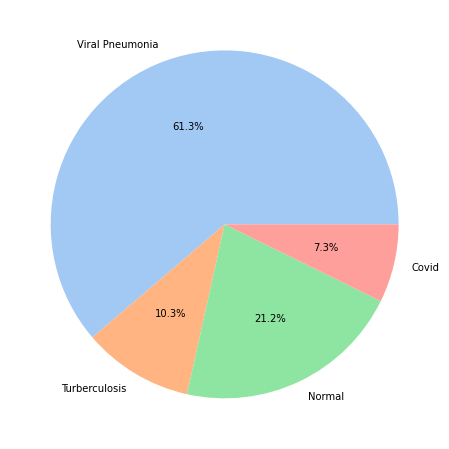

In [25]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

In [26]:
#visualize
import matplotlib.pyplot as plt
from ipywidgets import interact

In [27]:
# 이미지 파일을 RGB 3차원 배열로 불러오기
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [33]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list), len(turberculosis_list))

@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    turberculosis_image = get_RGB_image(data_dir, turberculosis_list[index])

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.title("Normal")
    plt.imshow(normal_image)
    plt.subplot(142)
    plt.title("Covid")
    plt.imshow(covid_image)
    plt.subplot(143)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)
    plt.subplot(144)
    plt.title("Turberculosis")
    plt.imshow(turberculosis_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=459), Output()), _dom_classes=('widget-inter…

In [39]:
# Crop image 를 저장하기 위한 폴더 생성

#os.mkdir(img_path+'Crop')
#os.mkdir(img_path+'Crop/Train')
#os.mkdir(img_path+'Crop/Test')

#os.mkdir(img_path+'Crop/MODEL/')
#os.mkdir(img_path+'Crop/Tensorboard/')

#for i in classes :
###create directory for training data
#    os.mkdir(img_path+'Crop/Train/'+i)
#    os.mkdir(img_path+'Crop/Test/'+i)

In [40]:
def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [42]:

dims = 255

for x in classes :

  j = 0
  for i in tqdm(os.listdir(train_dir +x)):
    path = os.path.join(train_dir +x, i)
    img = cv2.imread(path)
    

    if img is not None:
      img = crop_image(img, plot=False)
      img = cv2.resize(img, (dims, dims))
      save_path = img_path+'Crop/Train/'+ x+'/' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1

for x in classes :

  j = 0
  for i in tqdm(os.listdir(test_dir +x)):
    path = os.path.join(test_dir +x, i)
    img = cv2.imread(path)
    

    if img is not None:
      img = crop_image(img, plot=False)
      img = cv2.resize(img, (dims, dims))
      save_path = img_path+'Crop/Test/'+ x+'/' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1



100%|██████████| 106/106 [00:08<00:00, 12.65it/s]


In [43]:

#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory(img_path+'Crop/Train/',
                                         target_size=(dims, dims),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory(img_path+'Crop/Train/',
                                         target_size=(dims, dims),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory(img_path+'Crop/Test/',
                                         target_size=(dims, dims),
                                        class_mode='categorical',
                                        shuffle=False)

Found 5061 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [48]:
test_data.__getitem__(0)[1]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [49]:
img_width, img_height = 224, 224
batch_size = 32

In [50]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'Covid': 0, 'Normal': 1, 'Turberculosis': 2, 'Viral Pneumonia': 3}
{'Covid': 0, 'Normal': 1, 'Turberculosis': 2, 'Viral Pneumonia': 3}


In [51]:
Image, Label = train_data.__getitem__(0)

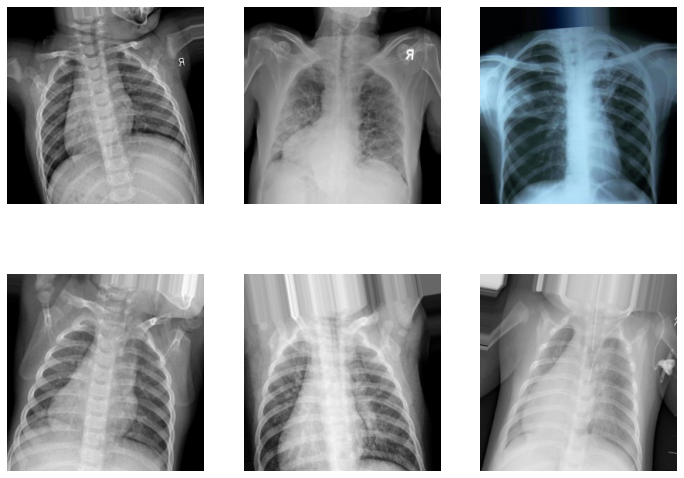

In [52]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
#build the model

#availabel model : https://keras.io/api/applications/

CNNmodel = InceptionResNetV2(weights='imagenet', 
                        include_top=False, 
                        input_shape=(dims, dims, 3))

model = CNNmodel.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(len(classes), activation='softmax')(model)
model = Model(inputs=CNNmodel.input, 
              outputs=model)

#get summary()
model.summary()

In [28]:
# compile model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
########## Training Start
history = model.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, reduce_lr])#earlystop, ])
###########

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9964
Epoch 1: val_accuracy improved from -inf to 0.88406, saving model to model.h5
9/9 [==============================] - 33s 2s/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.3425 - val_accuracy: 0.8841 - lr: 1.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9964
Epoch 2: val_accuracy improved from 0.88406 to 0.94203, saving model to model.h5
9/9 [==============================] - 12s 1s/step - loss: 0.0088 - accuracy: 0.9964 - val_loss: 0.1871 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.94203
9/9 [==============================] - 9s 910ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3209 - val_accuracy: 0.8986 - lr: 1.0000e-04
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.0239 - accur

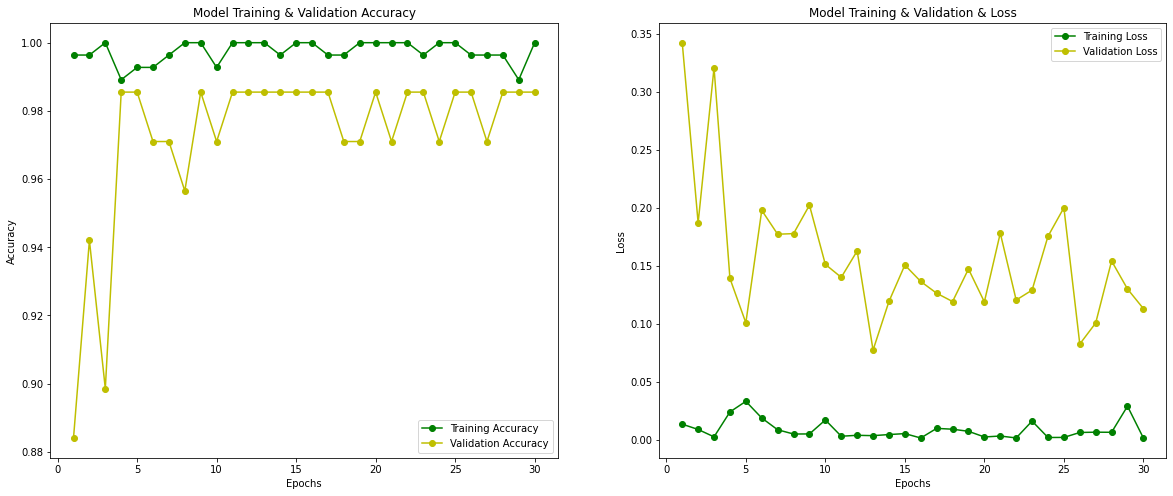

In [30]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [31]:
print('Train loss & accuracy :', model.evaluate(train_data))
print('\n')
print('Test loss & accuracy :', model.evaluate(test_data))

9/9 [==============================] - 5s 524ms/step - loss: 0.0047 - accuracy: 0.9964
Train loss & accuracy : [0.004733661189675331, 0.9963768124580383]


3/3 [==============================] - 2s 599ms/step - loss: 0.0499 - accuracy: 0.9848
Test loss & accuracy : [0.04985516890883446, 0.9848484992980957]


In [32]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

[[26  0  0]
 [ 0 19  1]
 [ 0  2 18]]


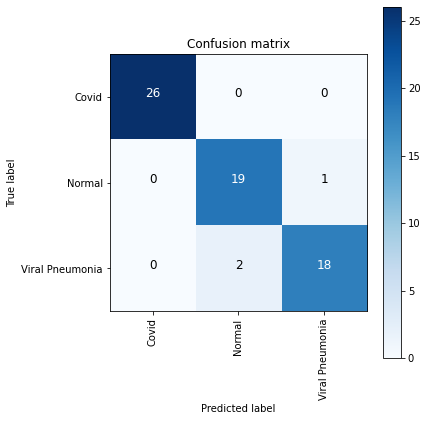

In [27]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
      
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)


In [28]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.90      0.95      0.93        20
           2       0.95      0.90      0.92        20

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



In [29]:
reverse_dict= dict(map(reversed,test_data.class_indices.items()))

In [30]:

#https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"
    
    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    
    #expand dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    
    #predict
    prediction = model.predict(img)
    
    #prediction index
    prediction_idx = np.argmax(prediction)
    
    #STEP 2: Create new model
    #specify last convolutional layer
    # last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    
    
    target_layer = model.get_layer(last_conv_layer.name)
    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]
    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)
    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]
    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)
    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)
    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img))
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
        print(f"Prediction = {reverse_dict[np.argmax(prediction)]}")
        # print(test_data.class_indices.keys(np.argmax(prediction)))
        
    else:
        return cvt_heatmap


Original = Covid
Prediction = Covid


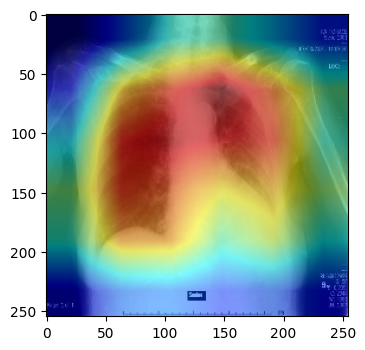

In [31]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[0] + "/8.jpg")

#apply function
print(f"Original = {classes[0]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

Original = Normal
Prediction = Normal


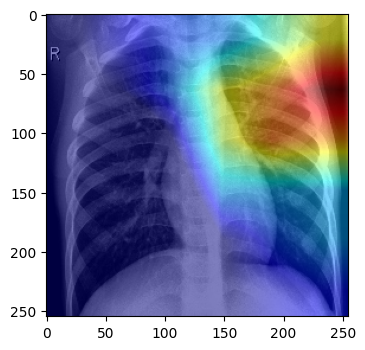

In [32]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[1] + "/17.jpg")

#apply function
print(f"Original = {classes[1]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

Original = Viral Pneumonia
Prediction = Viral Pneumonia


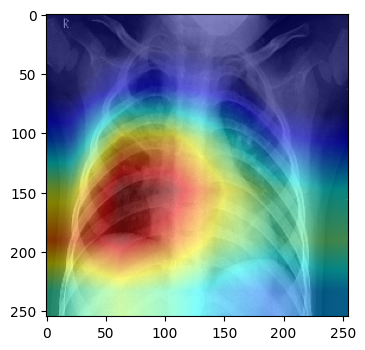

In [33]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[2] + "/5.jpg")

#apply function
print(f"Original = {classes[2]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [34]:
# import cv2
# import sys
             
# for i in os.listdir(img_path+'Test-Data/new_test'):   
#   if not i.startswith('.') :
#     # code to open the image
#     example_image = cv2.imread(os.path.join(img_path+'Test-Data/new_test', i))
#     img = cv2.resize(example_image, (240, 240))

#     #apply function
#     VizGradCAM(model, img_to_array(img), plot_results=True)
    
#     img= np.expand_dims(example_image, axis=0)
#     predict = model.predict(img)
#     predict = np.argmax(predict)
#     print(class_dict[predict])    
#   else :
#     pass
